In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7360081437279901565
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15425500971006576133
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [16]:
PATH = '/content/drive/MyDrive/classifiy_train_data_V4'
train_dir = PATH
validation_dir = '/content/drive/MyDrive/val_image_V4'

train_dir = PATH
class_num = 11

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2224 files belonging to 11 classes.
Found 522 files belonging to 11 classes.


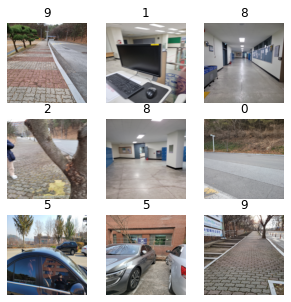

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input # 전처리가 모델에 포함되어 동작 없음
IMG_SHAPE = IMG_SIZE + (3,)
# Create the base model from the pre-trained model MobileNet V3
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=True,
                                                )
input = base_model.input
outputs = base_model.layers[-5].output  # dropout
new_model = tf.keras.Model(inputs=input, outputs=outputs) 
 # 모바일 넷의 아래 레이어 4개 자른 새로운 모델 생성

In [19]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape , label_batch)
feature_batch = new_model(image_batch)
print(feature_batch.shape)
feature_batch = tf.keras.layers.Flatten()(feature_batch)
print(feature_batch.shape)
feature_batch = tf.keras.layers.Dense(class_num,activation='softmax')(feature_batch)
print(feature_batch.shape)

(32, 224, 224, 3) tf.Tensor(
[ 0  1  0  9 10 10  6  9  9  7  9 10 10  7  4  9  6  9  9  9  1  5  6  2
  1  7  5  7 10  5  0 10], shape=(32,), dtype=int32)
(32, 1, 1, 1024)
(32, 1024)
(32, 11)


In [20]:
new_model.trainable = False
prediction_layer = tf.keras.layers.Dense(class_num,activation = 'softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = new_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

17/17 [==============================] - 13s 298ms/step - loss: 2.3652 - accuracy: 0.1437


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.37
initial accuracy: 0.14


In [23]:
train_dataset.class_names

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [28]:
base_learning_rate = 0.00002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
with tf.device('/device:GPU:0'): 
  history = model.fit(train_dataset,
                      epochs=30,
                      validation_data=validation_dataset
                      )

Epoch 1/30
70/70 [==============================] - 13s 141ms/step - loss: 0.2178 - accuracy: 0.9447 - val_loss: 0.6434 - val_accuracy: 0.8314
Epoch 2/30
70/70 [==============================] - 10s 126ms/step - loss: 0.2075 - accuracy: 0.9447 - val_loss: 0.6435 - val_accuracy: 0.8314
Epoch 3/30
70/70 [==============================] - 10s 132ms/step - loss: 0.2114 - accuracy: 0.9492 - val_loss: 0.6436 - val_accuracy: 0.8314
Epoch 4/30
70/70 [==============================] - 11s 132ms/step - loss: 0.2108 - accuracy: 0.9469 - val_loss: 0.6431 - val_accuracy: 0.8314
Epoch 5/30
70/70 [==============================] - 10s 125ms/step - loss: 0.2070 - accuracy: 0.9447 - val_loss: 0.6439 - val_accuracy: 0.8314
Epoch 6/30
70/70 [==============================] - 10s 126ms/step - loss: 0.2071 - accuracy: 0.9424 - val_loss: 0.6439 - val_accuracy: 0.8333
Epoch 7/30
70/70 [==============================] - 10s 126ms/step - loss: 0.2068 - accuracy: 0.9456 - val_loss: 0.6438 - val_accuracy: 0.8333

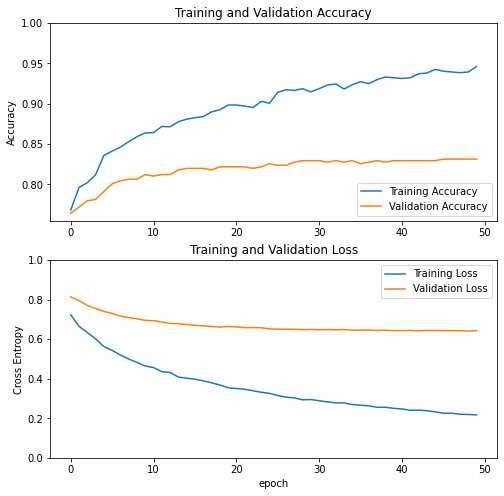

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
model.save('./saved_model/modelV5.h5')
tf.saved_model.save(model, './saved_model/demoV5/')

In [31]:
# 모델 tflite 로 변환
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_model/demoV5/')
tflite_model = converter.convert()

# Save the model.
with open('demoV5.tflite', 'wb') as f:
  f.write(tflite_model)